# Rayleigh projection depth experiments

In [15]:
import project_path
from src.util.tensor_projection_depth import tensor_outlying_function, vector_outlying_score
from scipy.linalg import eig, eigh
from src.util.graph import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from scipy.stats import multivariate_normal

## Two dimensional vector outlying function test
Generate two sets of two dimensional multivariate gaussian samples drawn from distinct distributions. Call one set the anomaly samples and other the normal ones. Using the samples at hand, find the empirical outlying score and calculate the AUC score.

In [10]:
nos = 1000
annos =100
rng = np.random.default_rng(0)
cov = np.array([[3,1.5],[1.5,3]])
cov2 = np.array([[5,-1],[-1,2]])
mean = np.array([0,0])
mean2= np.array([-2,2])
sn = rng.multivariate_normal(mean,cov,nos).T
an = rng.multivariate_normal(mean2,cov2,annos).T
of = np.zeros((nos,1))
af = np.zeros((annos,1))
for i in range(nos):
    of[i] = 1/(1+vector_outlying_score(sn[:,i],sn))
for i in range(annos):
    af[i] = 1/(1+vector_outlying_score(an[:,i],sn))

In [11]:
xlist = np.linspace(-7,7,100)
ylist = np.linspace(-7,7,100)
X, Y = np.meshgrid(xlist, ylist)

In [13]:
X

array([[-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       ...,
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ]])

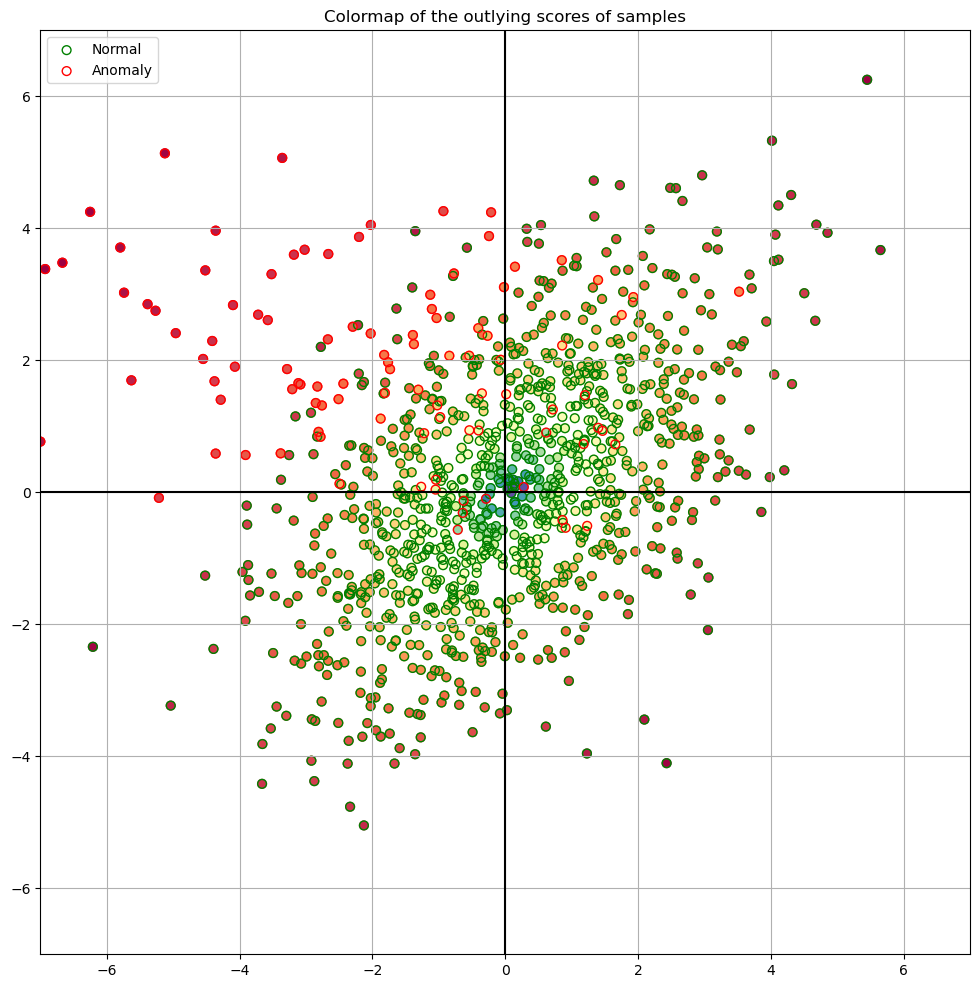

In [14]:
sizelim = 7
# plt.style.use('default')
fig, axe = plt.subplots(1,1, figsize=(12,12))
axe.scatter(sn[0,:],sn[1,:],s=40, c=of, cmap='Spectral')
axe.scatter(an[0,:],an[1,:],s=40, c=af, cmap='Spectral')
axe.scatter(sn[0,:],sn[1,:],s=40, facecolors='none',alpha=1, edgecolors='g',label='Normal')
axe.scatter(an[0,:],an[1,:],s=40, facecolors='none',alpha=1, edgecolors='r',label='Anomaly')
axe.vlines(0,ymin=-sizelim,ymax=sizelim,colors='k')
axe.hlines(0,xmin=-sizelim,xmax=sizelim,colors='k')
axe.set_xlim(-sizelim,sizelim)
axe.set_ylim(-sizelim,sizelim)
axe.set_title('Colormap of the outlying scores of samples')
axe.grid()
axe.legend()


Mean outlying score of normal data: 0.48176	 Anomalous data:0.34028
AUC-ROC score = 0.77100


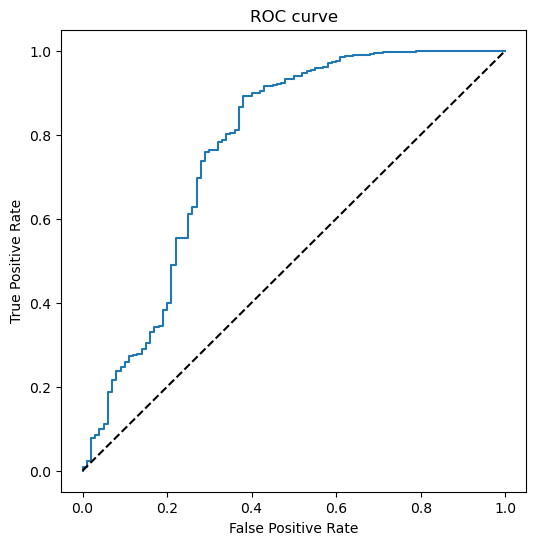

In [8]:
print(f"Mean outlying score of normal data: {np.mean(of):.5f}\t Anomalous data:{np.mean(af):.5f}")
y = np.ones((nos+annos,1))
pred = np.zeros((nos+annos,1))
pred[:nos] = of
pred[nos:] = af
y[nos:]=0
fpr, tpr, thresholds = metrics.roc_curve(y,pred,pos_label=1)
print(f"AUC-ROC score = {metrics.auc(fpr,tpr):.5f}")
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr,tpr)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve",
);

## Testing the Separability of smooth graph signals via rayleigh projection depth


In [77]:
rand_graph_params = {'dim': 10,'type': 'ba','g_params': 1}
G1 = Graph(rand_graph_params=rand_graph_params)
G2 = Graph(rand_graph_params=rand_graph_params)
GP1 = GraphProcess(Graph=G1, filter_type='Tikhonov',filter_parameters=10)
GP2 = GraphProcess(Graph=G2, filter_type='Tikhonov',filter_parameters=10)

Mean outlying score of normal data: 0.25203	 Anomalous data:0.19061
AUC-ROC score = 0.84245


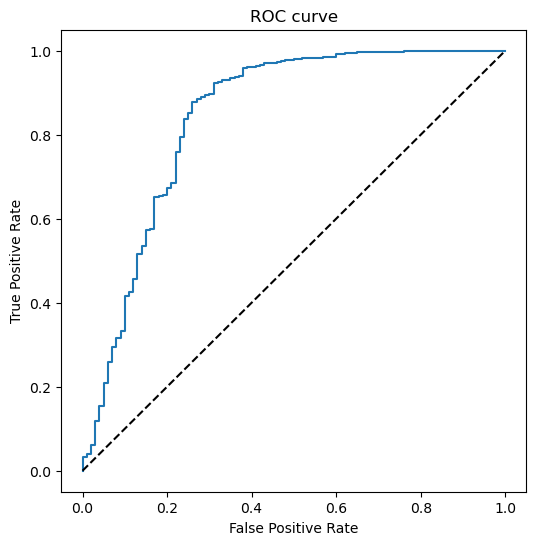

In [79]:
nos = 1000; annos=100
signal = GP1.gen_signal(nos,0)
sn = signal['X']
anomaly = GP2.gen_signal(annos,0)
an = anomaly['X']
all_samples = np.concatenate((sn,an),axis=1)
of = np.zeros((nos,1))
af = np.zeros((annos,1))
for i in range(nos):
    of[i] = 1/(1+vector_outlying_score(sn[:,i],sn))
for i in range(annos):
    af[i] = 1/(1+vector_outlying_score(an[:,i],sn))

print(f"Mean outlying score of normal data: {np.mean(of):.5f}\t Anomalous data:{np.mean(af):.5f}")
y = np.ones((nos+annos,1))
pred = np.zeros((nos+annos,1))
pred[:nos] = of
pred[nos:] = af
y[nos:]=0
fpr, tpr, thresholds = metrics.roc_curve(y,pred,pos_label=1)
print(f"AUC-ROC score = {metrics.auc(fpr,tpr):.5f}")
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr,tpr)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve",
);

In [86]:
rand_graph_params = {'dim': 10,'type': 'ba','g_params': 1}
factor_graph_params = [rand_graph_params,rand_graph_params,rand_graph_params]
kwargs = {
        'factor_graph_params': factor_graph_params,
        'product_type': 'cart'
        }

PG = ProductGraph(**kwargs)
PG2 = ProductGraph(**kwargs)
GP = GraphProcess(Graph=PG, filter_type='Heat',filter_parameters=10)
GP2 = GraphProcess(Graph=PG2, filter_type='Heat',filter_parameters=10)

In [100]:
noa = 100; nos =100
signal = GP.gen_signal(nos,0)
Xs = signal['X']
anomaly = GP2.gen_signal(noa,0)
Zs = [anomaly['X'][...,i] for i in range(anomaly['X'].shape[3])]
Nn = [Xs[...,i] for i in range(Xs.shape[3])] 
Sn = Zs

In [99]:
a_of = np.zeros(noa)
normal_of = np.zeros(nos)
for i in range(len(Zs)): 
    a_of[i], o_l=  tensor_outlying_function(Zs[i], Sn, maxit=200, err_tol=1e-4, v=2, seed=10, return_Us=False)
for i in range(len(Nn)): 
    normal_of[i], o_l=  tensor_outlying_function(Nn[i], Sn, maxit=200, err_tol=1e-4, v=2, seed=10, return_Us=False)

(array([-3.34110183e-18, -1.73149993e-18, -7.82862769e-19, -3.17728549e-19,
       -5.48666715e-20,  7.08439677e-20,  6.88105183e-19,  1.81713990e-18,
        3.19062161e-18,  2.16765358e-03]), array([[ 0.13443591,  0.59314561,  0.        ,  0.63283809,  0.        ,
         0.        , -0.42616786,  0.12820008,  0.06099839,  0.16687157],
       [-0.39255591,  0.4487949 , -0.14713434, -0.09535876, -0.01327632,
        -0.03394757,  0.02612492, -0.36587455, -0.59489209, -0.35209259],
       [-0.48869144, -0.27560131,  0.07642647,  0.11117644,  0.16116613,
         0.02654865, -0.14068092,  0.04627937, -0.37198593,  0.69284745],
       [-0.02473813, -0.06058721, -0.22971891,  0.02295711, -0.31512593,
        -0.9063084 , -0.02501632, -0.0676896 ,  0.05403191,  0.11658902],
       [-0.05087014,  0.07108409,  0.0448533 , -0.52997649, -0.27136395,
         0.1326342 , -0.70292331, -0.253324  ,  0.21375378,  0.11948747],
       [ 0.20392003, -0.38036937,  0.17795018,  0.25406616, -0.613409  

IndexError: index 5 is out of bounds for axis 0 with size 5

In [69]:
i=0
sz = Sn[5].shape
Snc = [s.copy() for s in Sn] 
kept_ranks = []
Sn_i = [t2m(s,i+1) for s in Sn] # 
M = sum(Sn_i)/len(Sn_i)         # Find the mean
C = sum([(s-M)@(s-M).T for s in Sn_i])/len(Sn)
lda, u = eigh(C)
lda


array([1.67886645, 2.94187989, 5.07308806, 6.28404169])

In [96]:
o, o_l=  tensor_outlying_function(Sn[5], Sn, maxit=100, err_tol=1e-1, v=2, seed=10, return_Us=False)

IndexError: list index out of range

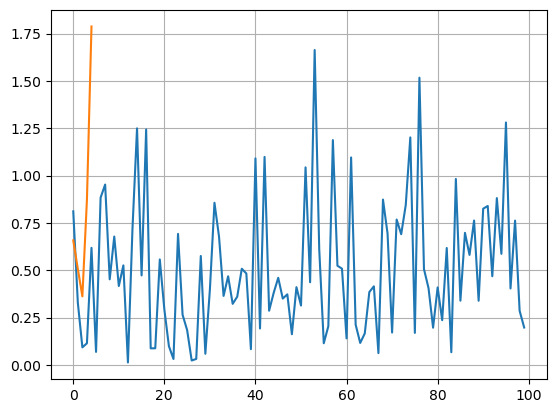

In [97]:
izelim = 7
fig, axe = plt.subplots(1,1)
axe.plot(normal_of)
axe.plot(a_of)
# axe.plot(o_l)
# axe.vlines(0,ymin=-sizelim,ymax=sizelim,colors='k')
# axe.hlines(0,xmin=-sizelim,xmax=sizelim,colors='k')
# axe.set_xlim(-sizelim,sizelim)
# axe.set_ylim(-sizelim,sizelim)
axe.grid()